## Load Libraries

In [ ]:
#!pip3 install nltk
#!pip3 install bert-score
#!pip3 install ezodf
#!pip install lxml
#!pip install scipy


In [1]:
import os
import csv
import re
import sys
import torch
import difflib
from edit_distance import str_edit_distance
import pandas as pd
import string
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from bert_score import BERTScorer
import ezodf
import ast
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import numpy as np

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('maxent_ne_chunker')
nltk.download('words')




/home/user/Documents/GitHub/CA-NMT_evaluation/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package maxent_ne_chunker 

True

## Context Aware Multi-encoder Model

# Edit distance, BLEU & BERT scores 

In [13]:
# Function to tokenize and remove punctuation and handle contractions
def tokenize_and_remove_punctuation(text):
    if pd.notna(text):
        cleaned_text = str(text)
        cleaned_text = re.sub(r"\bquot\b|-", "", text)

        # Handle contractions
        contractions_dict = {
            r"\bcan't\b": "cannot",
            r"\bhaven't\b": "have not",
            r"\bdon't\b": "do not",
            r"\bthat's\b": "that is",
            r"\bdoesn't\b": "does not",
            r"\bit's\b": "it is",
            r"\bi'm\b": "i am",
            r"\bwe're\b": "we are",
            r"\byou're\b": "you are",
            r"\bthey're\b": "they are",
            r"\bdidn't\b": "did not",
            r"\bwasn't\b": "was not",
            r"\bwon't\b": "will not",
            r"\bwouldn't\b": "would not",
            r"\bshouldn't\b": "should not",
            r"\bcouldn't\b": "could not",
            r"\baren't\b": "are not",
            r"\bdaren't\b": "dare not",
            r"\bneedn't\b": "need not",
            # Add more contractions and their expansions as needed
        }

        for contraction, expansion in contractions_dict.items():
            cleaned_text = re.sub(contraction, expansion, cleaned_text)
        
        tokens = cleaned_text.split()
        tokens = [token.strip(string.punctuation) for token in tokens]
        tokens = [token for token in tokens if token]

        cleaned_text = ' '.join(tokens)

        return cleaned_text
    else:
        return ""

# Function to compute metrics and print results
def compute_metrics(ref_column, hyp_column, data_prefix):
    edit_distances = []
    bleu_scores = []
    bert_scores = []

    # Load the BERTScore model
    scorer = BERTScorer(lang="en", rescale_with_baseline=True)

    # Create a SmoothingFunction instance
    smooth_func = SmoothingFunction()

    for ref_str, hyp_str in zip(ref_column, hyp_column):
        ref_str = str(ref_str)
        hyp_str = str(hyp_str)
        cleaned_ref = tokenize_and_remove_punctuation(ref_str.strip())
        cleaned_hyp = tokenize_and_remove_punctuation(hyp_str.strip())

        # Compute Edit Distance
        er_vals = str_edit_distance(cleaned_ref.strip(), cleaned_hyp)
        edit_distance = sum(er_vals[:3]) / er_vals[3]
        edit_distances.append(edit_distance)

        ref_tokens = nltk.word_tokenize(cleaned_ref)
        hyp_tokens = nltk.word_tokenize(cleaned_hyp)
        bleu_score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smooth_func.method1)
        bleu_scores.append(bleu_score)

        _, _, bert_score = scorer.score([cleaned_hyp], [cleaned_ref])
        bert_scores.append(bert_score.item())

        if er_vals[3] == 0:
            print(f'{data_prefix} - Reference:', cleaned_ref.strip())
            print(f'{data_prefix} - Hypothesis:', cleaned_hyp)
            print('---')
            print(f'{data_prefix} - Hyp File:', cleaned_hyp)
            print(f'{data_prefix} - Error rate: N/A (Reference length is zero)')
            print('---')
            continue

        print(f'{data_prefix} - Computing edit distance between:')
        print(f'{data_prefix} - ref: {cleaned_ref}')
        print(f'{data_prefix} - hyp: {cleaned_hyp}')
        print(' ---')

        er_vals = str_edit_distance(cleaned_ref, cleaned_hyp)

        print(f'{data_prefix} - ER: {sum(er_vals[:3])/er_vals[3]:.2f}')
        print(f'{data_prefix} - Errors:')
        print(f'{data_prefix} - ins: {er_vals[0]}')
        print(f'{data_prefix} - del: {er_vals[1]}')
        print(f'{data_prefix} - sub: {er_vals[2]}')
        print(' ---')

        rtoks = cleaned_ref.split()
        htoks = cleaned_hyp.split()
        alignment = er_vals[4]
        print(f'{data_prefix} - Alignment:')
        for t in alignment:
            print(f'{data_prefix} - {t[0]}) r:{rtoks[t[1]]}, h:{htoks[t[2]] if t[2] is not None else "-"}')
        print(' ---')

    return edit_distances, bleu_scores, bert_scores


# Path to the file
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis.ods"

# Load the data from the file into a pandas DataFrame
data = pd.read_excel(file_path)

# Get the values from the "Target_De" and "Output" columns (from Code 1)
ref_column = data["Target_De"].values
hyp_column = data["Output"].values

# Get the values from the "Current_Sentence_En" and "English_Translation" columns (from Code 2)
ref_column_translation = data["Current_Sentence_En"].values
hyp_column_translation = data["English_Translation"].values


# Compute metrics for the first set of data
edit_distances, bleu_scores, bert_scores = compute_metrics(ref_column, hyp_column, "Original version")

# Add the metrics as new columns in the DataFrame for the first set of data
data["Edit_distance"] = edit_distances
data["BLEU_score"] = bleu_scores
data["BERT_score"] = bert_scores

# Compute metrics for the second set of data
edit_distances_translation, bleu_scores_translation, bert_scores_translation = compute_metrics(ref_column_translation, hyp_column_translation, "Translation version")

# Add the metrics as new columns in the DataFrame for the second set of data
data["Edit_distance_translation"] = edit_distances_translation
data["BLEU_score_translation"] = bleu_scores_translation
data["BERT_score_translation"] = bert_scores_translation

# Save the updated DataFrame back to the file
data.to_excel(file_path, index=False)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original version - Computing edit distance between:
Original version - ref: Sie ist ein armseliger minderwertiger Ersatz für die Realität – ein kläglicher Versuch dem Leben zu entfliehen
Original version - hyp: Sie ist ein armseliger minderwertiger Ersatz für die Realität ein kläglicher Versuch dem Leben zu entfliehen
 ---
Original version - ER: 0.06
Original version - Errors:
Original version - ins: 0
Original version - del: 1
Original version - sub: 0
 ---
Original version - Alignment:
Original version - match) r:Sie, h:Sie
Original version - match) r:ist, h:ist
Original version - match) r:ein, h:ein
Original version - match) r:armseliger, h:armseliger
Original version - match) r:minderwertiger, h:minderwertiger
Original version - match) r:Ersatz, h:Ersatz
Original version - match) r:für, h:für
Original version - match) r:die, h:die
Original version - match) r:Realität, h:Realität
Original version - del) r:–, h:-
Original version - match) r:ein, h:ein
Original version - match) r:kläg

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Translation version - Computing edit distance between:
Translation version - ref: It is a pathetic little secondrate substitute for reality a pitiable flight from life
Translation version - hyp: It is a poor inferior substitute for reality a pitiful attempt to escape from life
 ---
Translation version - ER: 0.50
Translation version - Errors:
Translation version - ins: 2
Translation version - del: 1
Translation version - sub: 4
 ---
Translation version - Alignment:
Translation version - match) r:It, h:It
Translation version - match) r:is, h:is
Translation version - match) r:a, h:a
Translation version - del) r:pathetic, h:-
Translation version - sub) r:little, h:poor
Translation version - sub) r:secondrate, h:inferior
Translation version - match) r:substitute, h:substitute
Translation version - match) r:for, h:for
Translation version - match) r:reality, h:reality
Translation version - match) r:a, h:a
Translation version - ins) r:a, h:pitiful
Translation version - ins) r:a, h:attempt
Tran

## Analysis 

## Top 10 tokens

In [3]:
def top_10(file_path):
    # Function to check if the token starts with a capital letter
    def starts_with_capital(token):
        if isinstance(token, list):
            return token[0][0].isupper()
        elif isinstance(token, str):  # Handle cases where 'token' is a string
            return token[0].isupper()
        return False  # Return False for missing values (NaN)

    # Read the ODS file
    ods_file = ezodf.opendoc(file_path)
    sheet = ods_file.sheets[0]
    data = [[cell.value for cell in row] for row in sheet.rows()]

    # Create a DataFrame from the data
    df = pd.DataFrame(data[1:], columns=data[0])

    # Convert 'Attention_score_Markable' column to numeric and drop rows with missing values
    df['Attention_score_Markable'] = pd.to_numeric(df['Attention_score_Markable'], errors='coerce')
    df.dropna(subset=['Attention_score_Markable'], inplace=True)

    # Drop rows with malformed or None values in the 'token' column
    df = df.dropna(subset=['token'])
    df['token_str'] = df['token'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    df = df[~df['token_str'].isin(['<pad>', "&apos;s"])]

    # Split tokens into two separate DataFrames based on capitalization
    capitalized_df = df[df['token'].apply(starts_with_capital)]
    non_capitalized_df = df[~df['token'].apply(starts_with_capital)]

    # Calculate the average attention score for each token group and get the count of each group
    capitalized_grouped = capitalized_df.groupby('token_str')['Attention_score_Markable']
    capitalized_avg_attention = capitalized_grouped.mean()
    capitalized_occurrences = capitalized_grouped.count()

    non_capitalized_grouped = non_capitalized_df.groupby('token_str')['Attention_score_Markable']
    non_capitalized_avg_attention = non_capitalized_grouped.mean()
    non_capitalized_occurrences = non_capitalized_grouped.count()

    # Merge the average attention and occurrences into a single DataFrame for each group
    top_10_capitalized_df = pd.DataFrame({
        'Average_Attention': capitalized_avg_attention,
        'Occurrences': capitalized_occurrences
    })
    top_10_non_capitalized_df = pd.DataFrame({
        'Average_Attention': non_capitalized_avg_attention,
        'Occurrences': non_capitalized_occurrences
    })

    # Filter out tokens that appear only once
    top_10_capitalized_df = top_10_capitalized_df[top_10_capitalized_df['Occurrences'] > 5]
    top_10_non_capitalized_df = top_10_non_capitalized_df[top_10_non_capitalized_df['Occurrences'] > 5]

    # Select the top 10 tokens with the highest average attention for each group
    top_10_capitalized_tokens = top_10_capitalized_df.nlargest(10, 'Average_Attention')
    top_10_non_capitalized_tokens = top_10_non_capitalized_df.nlargest(10, 'Average_Attention')

    print("Top 10 Capitalized Tokens with Highest Average Attention (appearing more than 4):")
    print(top_10_capitalized_tokens)

    print("\nTop 10 Non-Capitalized Tokens with Highest Average Attention (appearing more than 4):")
    print(top_10_non_capitalized_tokens)

# Define the file path
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis_extended.ods"

# Call the function to analyze the attention scores
top_10(file_path)


Top 10 Capitalized Tokens with Highest Average Attention (appearing more than 4):
           Average_Attention  Occurrences
token_str                                
And                 0.029587           30
I                   0.015971           37

Top 10 Non-Capitalized Tokens with Highest Average Attention (appearing more than 4):
           Average_Attention  Occurrences
token_str                                
['them']            0.530926            7
['They']            0.479451            7
['they']            0.441747            7
['It']              0.440035           12
['his']             0.338358           12
them                0.292553            7
['he']              0.282203           13
he                  0.255978           12
['it']              0.237945            8
['she']             0.208345           10


## Average Position of tokens

In [4]:
# Replace the file path with the actual file path on your system
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis_extended.ods"

# Read the file into a DataFrame
df = pd.read_excel(file_path, engine='odf')

# First, let's explode the 'token' column to separate the lists into individual rows
df_exploded = df.explode('token')

# Next, group by 'token' and calculate the average of 'Token_Position'
average_values = df_exploded.groupby('token')['Token_Position'].mean().reset_index()

# Convert 'Token_Position' column to integers
average_values['Token_Position'] = average_values['Token_Position'].astype(int)

# Filter rows with 'Token_Position' values between 1 and 10

print(average_values)

       token  Token_Position
0          1               6
1         23              14
2         30              12
3       1968               5
4    &apos;d              33
..       ...             ...
566      yes               6
567      yet               3
568      you              29
569    young              15
570     your               9

[571 rows x 2 columns]


In [5]:
tokens_to_find = ['them',"he", 'it', 'there', 'his', 'she', 'him', 'they', 'be', 'if']

for token in tokens_to_find:
    average_position = average_values[average_values['token'] == token]['Token_Position'].mean()
    print(f"Average position of the token '{token}': {average_position:.2f}")


Average position of the token 'them': 16.00
Average position of the token 'he': 18.00
Average position of the token 'it': 26.00
Average position of the token 'there': 18.00
Average position of the token 'his': 18.00
Average position of the token 'she': 16.00
Average position of the token 'him': 24.00
Average position of the token 'they': 19.00
Average position of the token 'be': 16.00
Average position of the token 'if': 24.00


## Average attention vs Token position

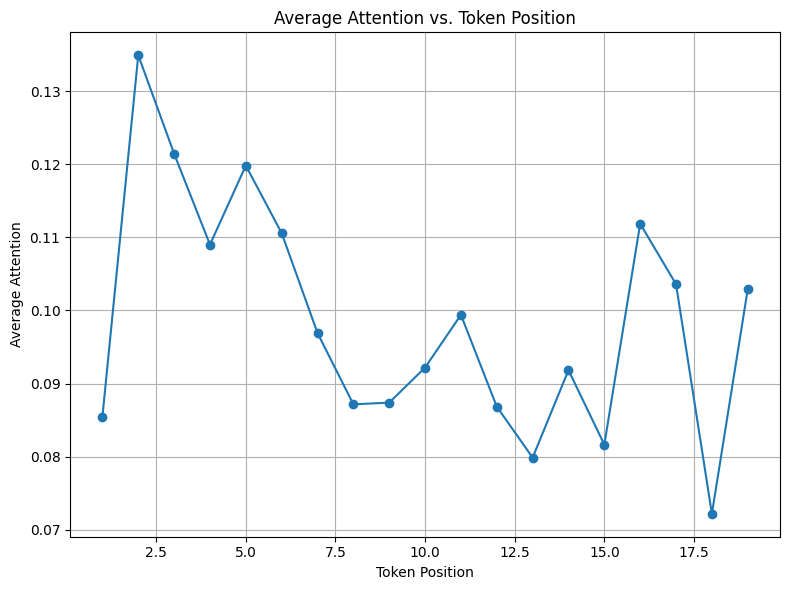

Correlation Coefficient: -0.460743765239941
P-value: 0.047112167848349575


In [6]:
def analyze_attention_scores_token_position(file_path):
    # Read data from the .ods file using pandas-ods-reader
    data = pd.read_excel(file_path, engine="odf")

    # Ensure the 'Attention_score_Markable' column contains numeric values
    data['Attention_score_Markable'] = pd.to_numeric(data['Attention_score_Markable'], errors='coerce')

    # Calculate the length of the source sentences and context sentences for each row
    data['Source_Length'] = data['Current_Sentence_En'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    data['Context_Length'] = data['Context'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

    # Filter out token positions 2-10
    data_filtered = data[(data['Token_Position'] >= 2) & (data['Token_Position'] <= 20)]

    # Group by 'Token_Position' and calculate the mean average attention for each position
    average_attention_by_position = data_filtered.groupby('Token_Position')['Attention_score_Markable'].mean()

    # Subtract 1 from the x-axis values to exclude token position 1 and shift the positions
    average_attention_by_position.index = average_attention_by_position.index - 1

    # Create the line plot
    plt.figure(figsize=(8, 6))
    plt.plot(average_attention_by_position.index, average_attention_by_position.values, marker='o', linestyle='-')
    plt.xlabel("Token Position")
    plt.ylabel("Average Attention")
    plt.title("Average Attention vs. Token Position")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate the correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(average_attention_by_position.index, average_attention_by_position.values)

    # Print the correlation coefficient and p-value
    print("Correlation Coefficient:", correlation_coefficient)
    print("P-value:", p_value)

# Example usage:
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis_extended.ods"
analyze_attention_scores_token_position(file_path)


##  Average attention to context words vs. both source and context length

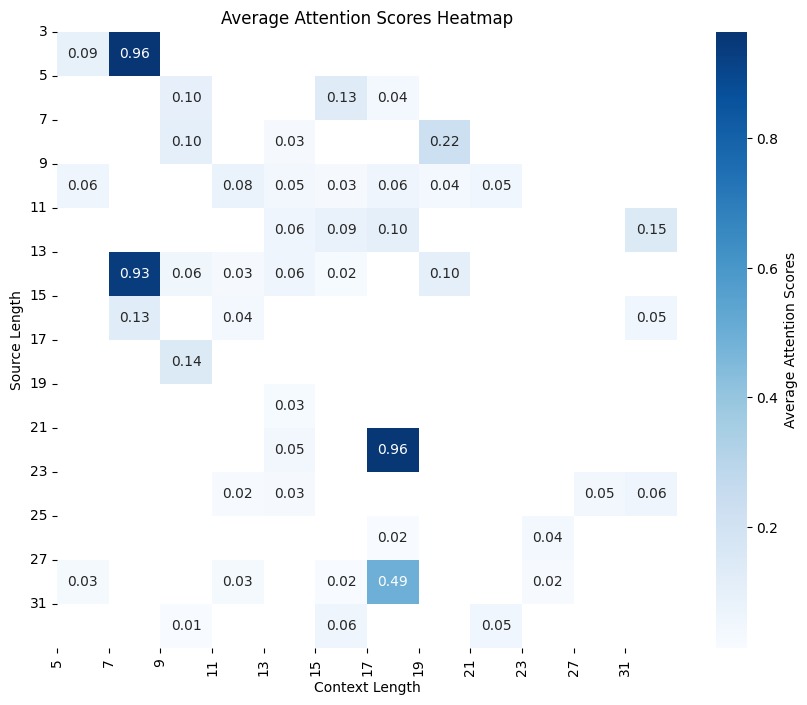

Pearson Correlation Coefficient (Source Length vs. Average Attention): r = -0.22, p = 0.000
Pearson Correlation Coefficient (Context Length vs. Average Attention): r = -0.12, p = 0.000


In [7]:

def average_attention_source_context_length(file_path):
    # Read data from the .ods file using pandas-ods-reader
    data = pd.read_excel(file_path, engine="odf")

    # Ensure the 'Attention_score_Markable' column contains numeric values
    data['Attention_score_Markable'] = pd.to_numeric(data['Attention_score_Markable'], errors='coerce')

    # Calculate the length of the source sentences and context sentences for each row
    data['Source_Length'] = data['Current_Sentence_En'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    data['Context_Length'] = data['Context'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

    # Group by 'Sentence_ID' and calculate the average attention score for each sentence
    data['Average_Attention'] = data.groupby('Sentence_ID')['Attention_score_Markable'].transform('mean')

    # Calculate the correlation between 'Source_Length' and 'Average_Attention'
    corr_coeff_source_attention, p_value_source_attention = pearsonr(data['Source_Length'], data['Average_Attention'])

    # Calculate the correlation between 'Context_Length' and 'Average_Attention'
    corr_coeff_context_attention, p_value_context_attention = pearsonr(data['Context_Length'], data['Average_Attention'])

    # Create a pivot table to organize the data for the heatmap
    # Create the pivot table with bins for Source Length and Context Length
    data['Source Length Bins'] = pd.cut(data['Source_Length'], bins=np.arange(1, 34, 2))  # Start from 1 and go up to 31
    data['Context Length Bins'] = pd.cut(data['Context_Length'], bins=np.arange(1, 34, 2))  # Start from 1 and go up to 31

    heatmap_data = data.pivot_table(index='Source Length Bins', columns='Context Length Bins', values='Average_Attention', aggfunc='mean')

    # Define custom labels for x and y axis based on the bins
    x_labels = ['{}'.format(int(x.left)) for x in heatmap_data.columns]
    y_labels = ['{}'.format(int(y.left)) for y in heatmap_data.index]

    # Plot the heatmap with beige fill and set vmin and vmax to cover the whole range of 2
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': 'Average Attention Scores'}, cbar=True, center=0.5)
    # ax.set_facecolor('beige')  # Set the face color of the heatmap to beige
    plt.xlabel('Context Length')
    plt.ylabel('Source Length')
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=90)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, rotation=0)
    plt.title('Average Attention Scores Heatmap')

    # Increase the font size for x and y axis labels
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)

    plt.show()

    # Print the correlation coefficients in APA style
    print(f"Pearson Correlation Coefficient (Source Length vs. Average Attention): r = {corr_coeff_source_attention:.2f}, p = {p_value_source_attention:.3f}")
    print(f"Pearson Correlation Coefficient (Context Length vs. Average Attention): r = {corr_coeff_context_attention:.2f}, p = {p_value_context_attention:.3f}")

# Usage example:
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis_extended.ods"
average_attention_source_context_length(file_path)


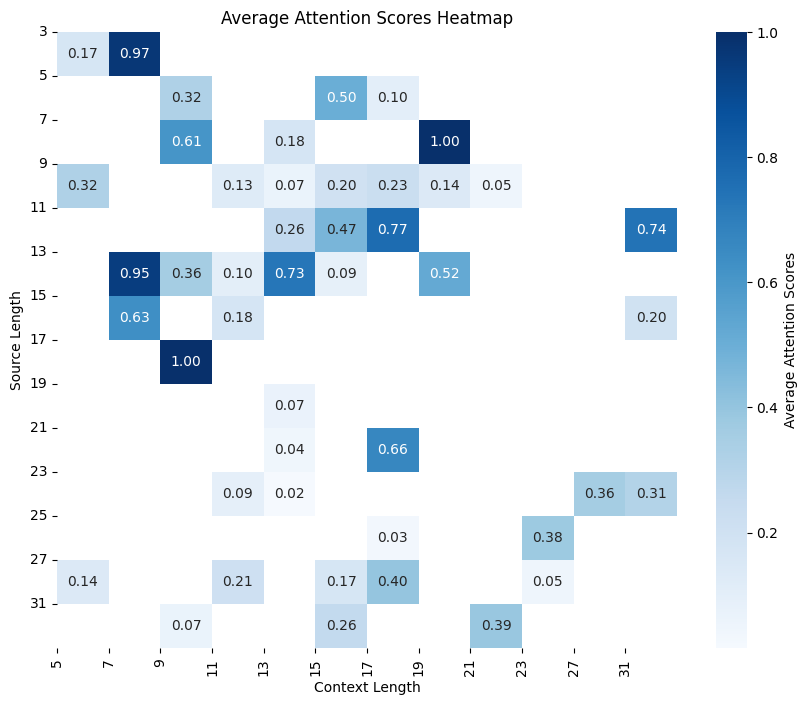

Pearson Correlation Coefficient (Source Length vs. Attention): r = -0.13, p = 0.204
Pearson Correlation Coefficient (Context Length vs. Attention): r = -0.03, p = 0.787


In [8]:
def attention_source_context_length(file_path):
    # Read data from the .ods file using pandas-ods-reader
    data = pd.read_excel(file_path, engine="odf")

    # Ensure the 'Attention_score_Markable' column contains numeric values
    data['Attention_score_Markable'] = pd.to_numeric(data['Attention_score_Markable'], errors='coerce')

    # Calculate the length of the source sentences and context sentences for each row
    data['Source_Length'] = data['Current_Sentence_En'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    data['Context_Length'] = data['Context'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

    # Group by 'Sentence_ID' and calculate the average attention score for each sentence
    data['Average_Attention'] = data.groupby('Sentence_ID')['Attention_score_Markable'].transform('mean')

    # Calculate the correlation between 'Source_Length' and 'Average_Attention'
    corr_coeff_source_attention, p_value_source_attention = pearsonr(data['Source_Length'], data['Attention_score_Markable'])

    # Calculate the correlation between 'Context_Length' and 'Average_Attention'
    corr_coeff_context_attention, p_value_context_attention = pearsonr(data['Context_Length'], data['Attention_score_Markable'])

    # Create a pivot table to organize the data for the heatmap
    # Create the pivot table with bins for Source Length and Context Length
    data['Source Length Bins'] = pd.cut(data['Source_Length'], bins=np.arange(1, 34, 2))  # Start from 1 and go up to 31
    data['Context Length Bins'] = pd.cut(data['Context_Length'], bins=np.arange(1, 34, 2))  # Start from 1 and go up to 31

    heatmap_data = data.pivot_table(index='Source Length Bins', columns='Context Length Bins', values='Average_Attention', aggfunc='mean')

    # Define custom labels for x and y axis based on the bins
    x_labels = ['{}'.format(int(x.left)) for x in heatmap_data.columns]
    y_labels = ['{}'.format(int(y.left)) for y in heatmap_data.index]

    # Plot the heatmap with beige fill and set vmin and vmax to cover the whole range of 2
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': 'Average Attention Scores'}, cbar=True, center=0.5)
    # ax.set_facecolor('beige')  # Set the face color of the heatmap to beige
    plt.xlabel('Context Length')
    plt.ylabel('Source Length')
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=90)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, rotation=0)
    plt.title('Average Attention Scores Heatmap')

    # Increase the font size for x and y axis labels
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)

    plt.show()

    # Print the correlation coefficients in APA style
    print(f"Pearson Correlation Coefficient (Source Length vs. Attention): r = {corr_coeff_source_attention:.2f}, p = {p_value_source_attention:.3f}")
    print(f"Pearson Correlation Coefficient (Context Length vs. Attention): r = {corr_coeff_context_attention:.2f}, p = {p_value_context_attention:.3f}")

# path
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis.ods"

attention_source_context_length(file_path)


## BLEU/BERT score vs. source sentence length

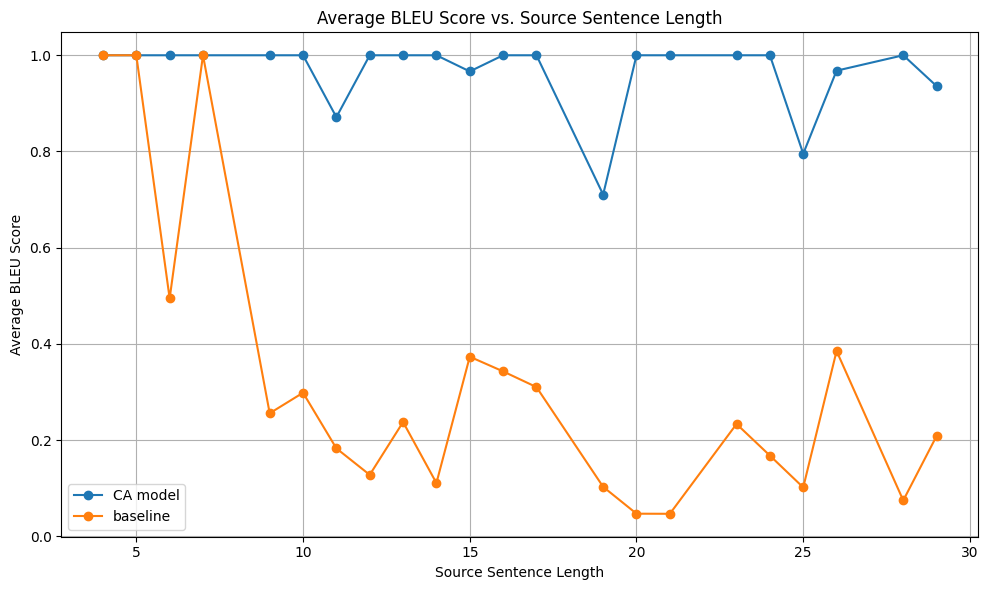

Correlation (CA): -0.22
P-value (CA): 0.0603
Correlation (baseline): -0.38
P-value (baseline): 0.0007


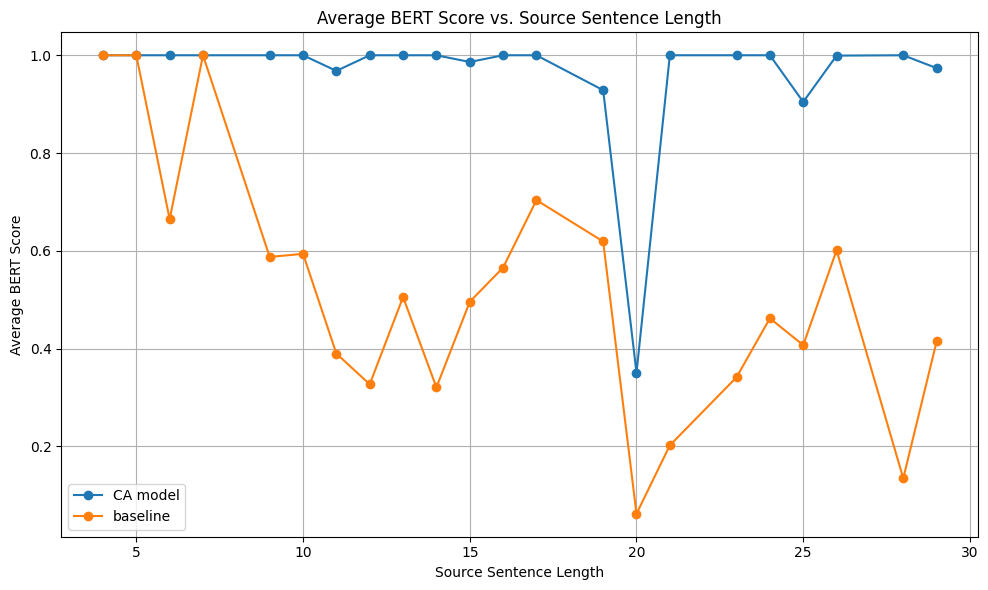

Correlation (CA): -0.12
P-value (CA): 0.2804
Correlation (baseline): -0.42
P-value (baseline): 0.0002


In [9]:
# Function to read data and perform analysis
def analyze_scores(file_path, score_column, baseline_column, score_label):
    # Read data from the .ods file using pandas-ods-reader
    data = pd.read_excel(file_path, engine="odf")

    # Filter out rows with 0 score
    data = data[data[score_column] != 0]
    data = data[data[baseline_column] != 0]

    # Calculate the length of the source sentences for each row
    data['Source_Length'] = data['Current_Sentence_En'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

    # Filter out source sentence lengths 1-30 (adjust as needed)
    data_filtered = data[(data['Source_Length'] >= 1) & (data['Source_Length'] <= 30)]

    # Group by 'Source_Length' and calculate the mean score for each length
    average_score_by_length = data_filtered.groupby('Source_Length')[score_column].mean()
    average_baseline_by_length = data_filtered.groupby('Source_Length')[baseline_column].mean()

    # Create the line plot
    plt.figure(figsize=(10, 6))
    plt.plot(average_score_by_length.index, average_score_by_length.values, marker='o', linestyle='-', label='CA model')
    plt.plot(average_baseline_by_length.index, average_baseline_by_length.values, marker='o', linestyle='-', label='baseline')
    plt.xlabel("Source Sentence Length")
    plt.ylabel(f"Average {score_label} Score")
    plt.title(f"Average {score_label} Score vs. Source Sentence Length")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate correlation and p-value between 'Source_Length' and the score
    correlation_CA, p_value_CA = pearsonr(data_filtered['Source_Length'], data_filtered[score_column])
    correlation_baseline, p_value_baseline = pearsonr(data_filtered['Source_Length'], data_filtered[baseline_column])

    # Print correlation and p-values
    print(f"Correlation (CA): {correlation_CA:.2f}")
    print(f"P-value (CA): {p_value_CA:.4f}")
    print(f"Correlation (baseline): {correlation_baseline:.2f}")
    print(f"P-value (baseline): {p_value_baseline:.4f}")

# Specify file paths and columns for BLEU and BERT score analysis
bleu_file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis.ods"
bert_file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis.ods"
bleu_score_column = 'BLEU_score'
bleu_baseline_column = 'Vanilla_transformer_BLEU_score'
bert_score_column = 'BERT_score'
bert_baseline_column = 'Vanilla_transformer_BERT_score'

# Analyze BLEU scores
analyze_scores(bleu_file_path, bleu_score_column, bleu_baseline_column, "BLEU")

# Analyze BERT scores
analyze_scores(bert_file_path, bert_score_column, bert_baseline_column, "BERT")


## Baseline

# Edit distance, BLEU & BERT scores 

In [10]:
# Function to tokenize and remove punctuation and handle contractions
def tokenize_and_remove_punctuation(text):
    if pd.notna(text):
        cleaned_text = str(text)
        cleaned_text = re.sub(r"\bquot\b|-", "", text)
        
        tokens = cleaned_text.split()
        tokens = [token.strip(string.punctuation) for token in tokens]
        tokens = [token for token in tokens if token]

        cleaned_text = ' '.join(tokens)

        return cleaned_text
    else:
        return ""

# Function to compute metrics and print results
def compute_metrics(ref_column, hyp_column, data_prefix):
    edit_distances = []
    bleu_scores = []
    bert_scores = []

    # Load the BERTScore model
    scorer = BERTScorer(lang="en", rescale_with_baseline=True)

    # Create a SmoothingFunction instance
    smooth_func = SmoothingFunction()

    for ref_str, hyp_str in zip(ref_column, hyp_column):
        ref_str = str(ref_str)
        hyp_str = str(hyp_str)
        cleaned_ref = tokenize_and_remove_punctuation(ref_str.strip())
        cleaned_hyp = tokenize_and_remove_punctuation(hyp_str.strip())

        # Compute Edit Distance
        er_vals = str_edit_distance(cleaned_ref.strip(), cleaned_hyp)
        edit_distance = sum(er_vals[:3]) / er_vals[3]
        edit_distances.append(edit_distance)

        ref_tokens = nltk.word_tokenize(cleaned_ref)
        hyp_tokens = nltk.word_tokenize(cleaned_hyp)
        bleu_score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smooth_func.method1)
        bleu_scores.append(bleu_score)

        _, _, bert_score = scorer.score([cleaned_hyp], [cleaned_ref])
        bert_scores.append(bert_score.item())

        if er_vals[3] == 0:
            print(f'{data_prefix} - Reference:', cleaned_ref.strip())
            print(f'{data_prefix} - Hypothesis:', cleaned_hyp)
            print('---')
            print(f'{data_prefix} - Hyp File:', cleaned_hyp)
            print(f'{data_prefix} - Error rate: N/A (Reference length is zero)')
            print('---')
            continue

        print(f'{data_prefix} - Computing edit distance between:')
        print(f'{data_prefix} - ref: {cleaned_ref}')
        print(f'{data_prefix} - hyp: {cleaned_hyp}')
        print(' ---')

        er_vals = str_edit_distance(cleaned_ref, cleaned_hyp)

        print(f'{data_prefix} - ER: {sum(er_vals[:3])/er_vals[3]:.2f}')
        print(f'{data_prefix} - Errors:')
        print(f'{data_prefix} - ins: {er_vals[0]}')
        print(f'{data_prefix} - del: {er_vals[1]}')
        print(f'{data_prefix} - sub: {er_vals[2]}')
        print(' ---')

        rtoks = cleaned_ref.split()
        htoks = cleaned_hyp.split()
        alignment = er_vals[4]
        print(f'{data_prefix} - Alignment:')
        for t in alignment:
            print(f'{data_prefix} - {t[0]}) r:{rtoks[t[1]]}, h:{htoks[t[2]] if t[2] is not None else "-"}')
        print(' ---')

    return edit_distances, bleu_scores, bert_scores

# Path to the file
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis.ods"

# Load the data from the file into a pandas DataFrame
data = pd.read_excel(file_path)

# Get the values from the "Target_De" and "Output" columns (from Code 1)
ref_column = data["Target_De"].values
hyp_column = data["Vanilla_transformer_output"].values

# Get the values from the "Current_Sentence_En" and "English_Translation" columns (from Code 2)
ref_column_translation = data["Current_Sentence_En"].values
hyp_column_translation = data["Vanilla_transformer_output_translation"].values

# Compute metrics for the first set of data
edit_distances, bleu_scores, bert_scores = compute_metrics(ref_column, hyp_column, "Original version")

# Add the metrics as new columns in the DataFrame for the first set of data
data["Vanilla_transformer_Edit_distance"] = edit_distances
data["Vanilla_transformer_BLEU_score"] = bleu_scores
data["Vanilla_transformer_BERT_score"] = bert_scores

# Compute metrics for the second set of data
edit_distances_translation, bleu_scores_translation, bert_scores_translation = compute_metrics(ref_column_translation, hyp_column_translation, "Translation version")

# Add the metrics as new columns in the DataFrame for the second set of data
data["Edit_distance_Vanilla_transformer_output_translation"] = edit_distances
data["BLEU_score_Vanilla_transformer_output_translation"] = bleu_scores
data["BERT_score_Vanilla_transformer_output_translation"] = bert_scores

# Save the updated DataFrame back to the file
data.to_excel(file_path, index=False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original version - Computing edit distance between:
Original version - ref: Sie ist ein armseliger minderwertiger Ersatz für die Realität – ein kläglicher Versuch dem Leben zu entfliehen
Original version - hyp: Es ist ein erbärmlicher kleiner Ersatz für die Realität ein erbärmlicher Flucht aus dem Leben
 ---
Original version - ER: 0.53
Original version - Errors:
Original version - ins: 0
Original version - del: 2
Original version - sub: 7
 ---
Original version - Alignment:
Original version - sub) r:Sie, h:Es
Original version - match) r:ist, h:ist
Original version - match) r:ein, h:ein
Original version - sub) r:armseliger, h:erbärmlicher
Original version - sub) r:minderwertiger, h:kleiner
Original version - match) r:Ersatz, h:Ersatz
Original version - match) r:für, h:für
Original version - match) r:die, h:die
Original version - match) r:Realität, h:Realität
Original version - sub) r:–, h:ein
Original version - sub) r:ein, h:erbärmlicher
Original version - sub) r:kläglicher, h:Flucht
Ori

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Translation version - Computing edit distance between:
Translation version - ref: It is a pathetic little secondrate substitute for reality a pitiable flight from life
Translation version - hyp: It is a pathetic little substitute for reality a pathetic escape from life
 ---
Translation version - ER: 0.21
Translation version - Errors:
Translation version - ins: 0
Translation version - del: 1
Translation version - sub: 2
 ---
Translation version - Alignment:
Translation version - match) r:It, h:It
Translation version - match) r:is, h:is
Translation version - match) r:a, h:a
Translation version - match) r:pathetic, h:pathetic
Translation version - match) r:little, h:little
Translation version - del) r:secondrate, h:-
Translation version - match) r:substitute, h:substitute
Translation version - match) r:for, h:for
Translation version - match) r:reality, h:reality
Translation version - match) r:a, h:a
Translation version - sub) r:pitiable, h:pathetic
Translation version - sub) r:flight, h:e

## Selected pronouns analysis: CA multi-encoder model vs Baseline model

## BLEU & BERT scores on selected pronouns

In [11]:
def BLEU_BERT_analysis(file_path, tokens, score_columns):
    # Read the ODS file into a DataFrame
    df = pd.read_excel(file_path)

    # Convert all tokens to lowercase for case-insensitive matching
    df['token'] = df['token'].str.lower()

    # Filter out rows with non-null values in the 'token' column
    df = df[df['token'].notna()]

    # Filter the rows containing the desired tokens
    df_filtered = df[df['token'].str.contains('|'.join(tokens))]

    # Keep only the specified score columns along with the 'token' column
    df_filtered = df_filtered[['token'] + score_columns]

    # Group by the 'token' column and calculate the average of the specified score columns
    grouped_data = df_filtered.groupby('token').mean()

    return grouped_data

# Define the file path, tokens, and score columns for BLEU scores
file_path_bleu = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis.ods"
tokens_bleu = ['this', 'those', 'its', 'him', 'their', 'them', 'these', "their", "him", "your", "he", "which", "who"]
score_columns_bleu = ['BLEU_score', 'Vanilla_transformer_BLEU_score']

# Define the file path, tokens, and score columns for BERT scores
file_path_bert = "/home/user/Documents/GitHub/CA-NMT_evaluation/Concatenation_model/manually_annotated_corpus/analysis.ods"
tokens_bert = ['this', 'those', 'its', 'him', 'their', 'them', 'these', "their", "him", "your", "he", "which", "who"]
score_columns_bert = ['BERT_score', 'Vanilla_transformer_BERT_score']

# Process and print BLEU scores
grouped_data_bleu = BLEU_BERT_analysis(file_path_bleu, tokens_bleu, score_columns_bleu)
print("BLEU Scores:")
print(grouped_data_bleu)

# Process and print BERT scores
grouped_data_bert = BLEU_BERT_analysis(file_path_bert, tokens_bert, score_columns_bert)
print("BERT Scores:")
print(grouped_data_bert)


BLEU Scores:
                                       BLEU_score  \
token                                               
['he']                                   0.837648   
['her']                                  0.969169   
['him']                                  0.979197   
['she']                                  0.984703   
['the', 'pink', 'one']                   1.000000   
['their']                                1.000000   
['them']                                 1.000000   
['these']                                1.000000   
['they']                                 0.995542   
['this', 'disease']                      1.000000   
['this', 'little', 'insect']             1.000000   
['this', 'one']                          0.710328   
['this']                                 1.000000   
['those', 'horizontal', 'identities']    1.000000   
['those', 'three', 'reasons']            1.000000   

                                       Vanilla_transformer_BLEU_score  
token        

## Identical markable analysis

In [12]:
def identical_markable_analysis(file_path, tokens):
    # Read the ODS file into a DataFrame
    df = pd.read_excel(file_path)

    # Convert all tokens to lowercase for case-insensitive matching
    df['token'] = df['token'].str.lower()

    # Filter out rows with non-null values in the 'token' column
    df = df[df['token'].notna()]

    # Filter the rows containing the desired tokens
    df_filtered = df[df['token'].str.contains('|'.join(tokens))]

    # Keep only the 'BLEU_score' and 'Vanilla_transformer_BLEU_score' columns along with the 'token' column
    df_filtered = df_filtered[['token', 'Identical_markable_translation', 'Vanilla_transformer_Identical_markable_translation']]

    # Add a 'count' column to the DataFrame to store the occurrences of each token
    df_filtered['count'] = 1

    # Group by the 'token' column and calculate the sum of 'count', 'Identical_markable_translation', and 'Vanilla_transformer_Identical_markable_translation'
    grouped_data = df_filtered.groupby('token').agg(
        count=('count', 'sum'),
        mean_identical_markable_translation=('Identical_markable_translation', 'mean'),
        mean_vanilla_identical_markable_translation=('Vanilla_transformer_Identical_markable_translation', 'mean')
    )

    return grouped_data

# Example usage:
file_path = "/home/user/Documents/GitHub/CA-NMT_evaluation/Multi-encoder_k3_model/manually_annotated_corpus/analysis.ods"
tokens = ['this', 'those', 'its', 'him', 'their', 'them', 'these', "their", "him", "your", "he", "which", "who"]

result = identical_markable_analysis(file_path, tokens)
print(result)


                                       count  \
token                                          
['he']                                    14   
['her']                                    4   
['him']                                    3   
['she']                                   14   
['the', 'pink', 'one']                     1   
['their']                                  1   
['them']                                   7   
['these']                                  1   
['they']                                  14   
['this', 'disease']                        1   
['this', 'little', 'insect']               1   
['this', 'one']                            1   
['this']                                   1   
['those', 'horizontal', 'identities']      1   
['those', 'three', 'reasons']              1   

                                       mean_identical_markable_translation  \
token                                                                        
['he']                     